# Проект: Обучение с учителем: качество модели  
 

*Описание проекта* 

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Задача проекта: разработка модели машинного обучения, которое решает задачу бинарной классификации, - определение, покпуательская активность снизится или останется на прежнем уровне. 

*Описание данных*

    market_file.csv - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. 
    market_money.csv - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.  
    market_time.csv - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.  
    money.csv - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.  

 *Шаг 1. Загрузка данных*

 *Шаг 2. Предобработка данных*

 *Шаг 3. Исследовательский анализ данных*

 *Шаг 4. Объединение таблиц*

 *Шаг 5. Корреляционный анализ*

 *Шаг 6. Использование пайплайнов*

 *Шаг 7. Анализ важности признаков*

 *Шаг 8. Сегментация покупателей*

 *Шаг 9. Общий вывод*

### Шаг 1. Загрузка данных

Предварительно импортируем необходимые файлы и библиотеки.

In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import phik
import re


from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from warnings import simplefilter

from scipy import stats as st


#настройка параметров отображения графиков
plt.rcParams["figure.figsize"] = (8, 8)

pth_market_file = '/datasets/market_file.csv'
pth_market_money = '/datasets/market_money.csv'
pth_market_time = '/datasets/market_time.csv'
pth_money = '/datasets/money.csv'

if os.path.exists(pth_market_file):
    market_file = pd.read_csv(pth_market_file, sep=',')
else:
    print('Something is wrong')
    
if os.path.exists(pth_market_money):
    market_money = pd.read_csv(pth_market_money, sep=',')
else:
    print('Something is wrong')
    
if os.path.exists(pth_market_time):
    market_time = pd.read_csv(pth_market_time, sep=',')
else:
    print('Something is wrong')
    
if os.path.exists(pth_money):
    money = pd.read_csv(pth_money, sep=';')
else:
    print('Something is wrong')

Напишем функцию для получения информации по датасетам.

In [3]:
def data_info(data):
    print("Общая информация о датасете:\n")
    display(data.info())
    print("\n5 случайных строк их датасета:\n")
    display(data.sample(5))
    print("\nОписание данных:\n")
    display(data.describe().T)
    print("\nКоличество пропусков:\n")
    display(data.isna().sum())
    print("\nКоличество явных дубликатов:\n")
    display(data.duplicated().sum())

#### Датасет market_file

Описание датасета:

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.  

    id                        - номер покупателя в корпоративной базе данных.  
    
    Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».  
    
    Тип сервиса               — уровень сервиса, например «премиум» и «стандарт».  
    
    Разрешить сообщать        — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.  
    
    Маркет_актив_6_мес        — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.  
    
    Маркет_актив_тек_мес      — количество маркетинговых коммуникаций в текущем месяце.  
    
    Длительность              — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.  
    
    Акционные_покупки         — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.  
    
    Популярная_категория      — самая популярная категория товаров у покупателя за последние 6 месяцев.  
    
    Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.  
    
    Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.  
    
    Ошибка_сервиса            — число сбоев, которые коснулись покупателя во время посещения сайта.  
    
    Страниц_за_визит          — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.  

In [4]:
data_info(market_file)

Общая информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  

None


5 случайных строк их датасета:



,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1080,216428,Прежний уровень,стандарт,да,4.9,5,595,0.15,Кухонная посуда,2,1,1,11
288,215636,Снизилась,стандарт,да,3.5,5,749,0.30,Товары для детей,1,6,5,6
1103,216451,Прежний уровень,премиум,да,3.5,4,972,0.18,Мелкая бытовая техника и электроника,3,1,6,5
575,215923,Снизилась,премиум,да,3.8,3,724,0.26,Косметика и аксесуары,1,0,4,13
1261,216609,Прежний уровень,премиум,да,4.7,4,935,0.14,Мелкая бытовая техника и электроника,3,1,3,8



Описание данных:



,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00



Количество пропусков:



id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64


Количество явных дубликатов:



0

Вывод: Типы данных в порядке, пропусков и явных дубликатов не обнаружено, в описании данных на первый взгляд аномалий не отмечено - на этом шаге данные выглядят хорошо. На следующих шагах будем проверять на наличие неявных дубликатов. 

#### Датасет market_money

   Описание данных:
   Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.  
    
    id      — номер покупателя в корпоративной базе данных.  
    
    Период  — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.  
    
    Выручка — сумма выручки за период.  

In [5]:
data_info(market_money)

Общая информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None


5 случайных строк их датасета:



,id,Период,Выручка
1443,215829,текущий_месяц,6636.2
2714,216252,препредыдущий_месяц,4536.0
2943,216329,препредыдущий_месяц,4659.0
139,215394,предыдущий_месяц,5420.0
1298,215780,текущий_месяц,5928.4



Описание данных:



,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2



Количество пропусков:



id         0
Период     0
Выручка    0
dtype: int64


Количество явных дубликатов:



0

Вывод: Типы данных в порядке, пропусков и явных дубликатов не обнаружено. В описании данных большая разница между третьим квартилем и максимальным значением - отметим это и разберем момент подробнее на шаге предподготовки данных. На следующих шагах будем проверять на наличие неявных дубликатов. 

#### Датасет market_time

   Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.  
    
    id     — номер покупателя в корпоративной базе данных.  
    Период — название периода, во время которого зафиксировано общее время.  
    минут  — значение времени, проведённого на сайте, в минутах.  

In [6]:
data_info(market_time)

Общая информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None


5 случайных строк их датасета:



,id,Период,минут
154,215425,текущий_месяц,11
75,215385,предыдцщий_месяц,10
2301,216498,предыдцщий_месяц,15
1649,216172,предыдцщий_месяц,16
2546,216621,предыдцщий_месяц,10



Описание данных:



,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0



Количество пропусков:



id        0
Период    0
минут     0
dtype: int64


Количество явных дубликатов:



0

Вывод: Типы данных в порядке, пропусков и явных дубликатов не обнаружено, в описании данных на первый взгляд аномалий не отмечено - на этом шаге данные выглядят хорошо. На следующих шагах будем проверять на наличие неявных дубликатов. 

#### Датасет money

    Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.  
    
    id — номер покупателя в корпоративной базе данных.  
    Прибыль — значение прибыли.  

In [7]:
data_info(money)

Общая информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


None


5 случайных строк их датасета:



,id,Прибыль
295,215643,"5,59"
618,215966,"2,35"
829,216177,"4,12"
274,215622,"2,98"
640,215988,"5,1"



Описание данных:



,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.5,375.421985,215348.0,215672.75,215997.5,216322.25,216647.0



Количество пропусков:



id         0
Прибыль    0
dtype: int64


Количество явных дубликатов:



0

Сразу приведем тип данных столбца "Прибыль" к вещественному, и обновим информацию по датасету.

In [8]:
data_info(money)

Общая информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


None


5 случайных строк их датасета:



,id,Прибыль
735,216083,"3,6"
112,215460,"4,92"
695,216043,"4,62"
67,215415,"3,4"
1237,216585,"3,3"



Описание данных:



,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.5,375.421985,215348.0,215672.75,215997.5,216322.25,216647.0



Количество пропусков:



id         0
Прибыль    0
dtype: int64


Количество явных дубликатов:



0

Вывод: Пропусков и явных дубликатов не обнаружено. На следующих шагах будем проверять на наличие неявных дубликатов. 

### Шаг 2. Предобработка данных


Сначала для всех датасетов сразу приведем наименования столбцов к одному виду:

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет:

Привет Дарья!

Предлагаю    
    
    ### Шаг 2. Предобработка данных   -----> ## Шаг 2. Предобработка данных

    
и Кроме того не терять других заголовках предусмотренных проектом, не нашёл где у тебя   
    
    Шаг 1. Загрузка данных

In [9]:
dfs = [
    market_file,
    market_money,
    market_time,
    money
]

for df in dfs:
    df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).replace(' ', '_').lower() for i in df.columns]
    print(df.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Index(['id', 'период', 'выручка'], dtype='object')
Index(['id', 'период', 'минут'], dtype='object')
Index(['id', 'прибыль'], dtype='object')


In [10]:
market_file['покупательская_активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [11]:
market_file['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [12]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')
market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [13]:
market_file['разрешить_сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [14]:
market_file['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [15]:
market_file.isna().sum().to_frame()

,0
id,0
покупательская_активность,0
тип_сервиса,0
разрешить_сообщать,0
маркет_актив_6_мес,0
маркет_актив_тек_мес,0
длительность,0
акционные_покупки,0
популярная_категория,0
средний_просмотр_категорий_за_визит,0


In [16]:
market_file.isnull().sum().to_frame()

,0
id,0
покупательская_активность,0
тип_сервиса,0
разрешить_сообщать,0
маркет_актив_6_мес,0
маркет_актив_тек_мес,0
длительность,0
акционные_покупки,0
популярная_категория,0
средний_просмотр_категорий_за_визит,0


In [17]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [18]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [19]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [20]:
market_money.isna().sum().to_frame()

,0
id,0
период,0
выручка,0


In [21]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [22]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [23]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [24]:
market_time.isna().sum().to_frame()

,0
id,0
период,0
минут,0


In [25]:
money['прибыль'] = money['прибыль'].replace(',','.', regex=True).astype(float)

Вывод: Привели названия столб во всех датафреймах к одному виду. Избавились от неявных дубликатов. Привели типы данных там, где это необходимо. Данные готовы к исследовательскому анализу.

### Шаг 3. Исследовательский анализ данных


#### Датафрейм market_file

Выведем описание для каждого столбца этого датафрейма.


In [26]:
display(market_file.head())
market_file.describe().T

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


In [27]:
def hist_show(data, column, bins, measure=''):
    data[column].hist(bins=bins)
    plt.title('График распределения величины ' + column)
    plt.xlabel(column + measure)
    plt.ylabel('кол-во ...')
    plt.show()
    plt.title('Боксплот величины ' + column)
    plt.ylabel(column + measure)
    plt.boxplot(x=data[column]);

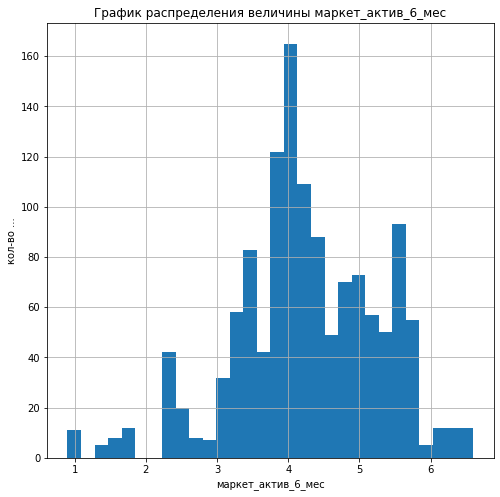

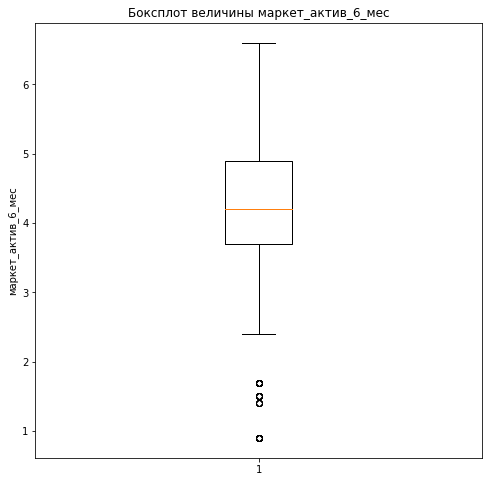

In [28]:
hist_show(market_file, 'маркет_актив_6_мес', bins=30)

Вывод: Данные выглядят нормально, есть несколько вбросов на значениях меньше 2х, но это ок для данного признака.

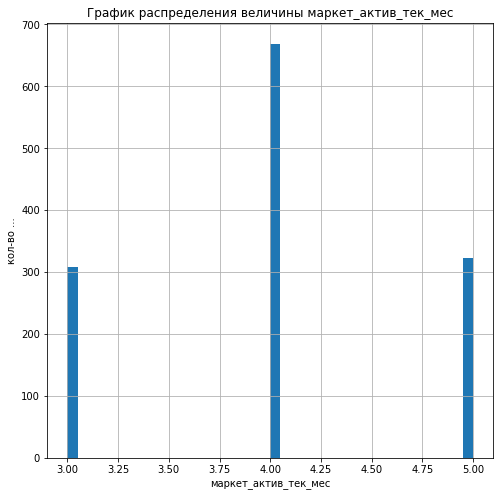

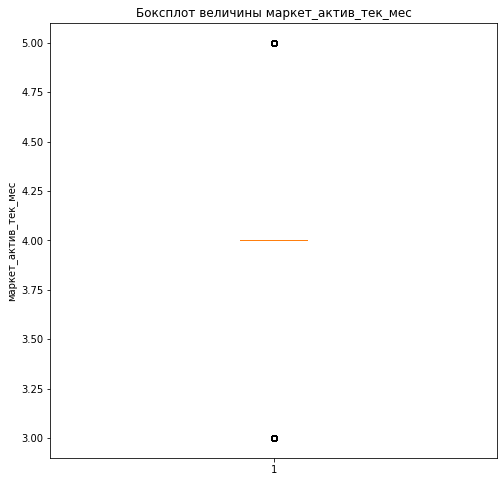

In [29]:
hist_show(market_file, 'маркет_актив_тек_мес', bins=40)

Вывод: Признак 'маркет_актив_тек_мес' имеет всего 3 значения, поэтому можем отнести его к кандидатам на перевод в категориальные признаки.

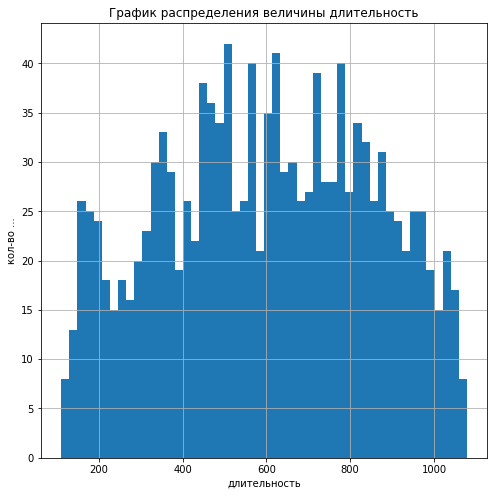

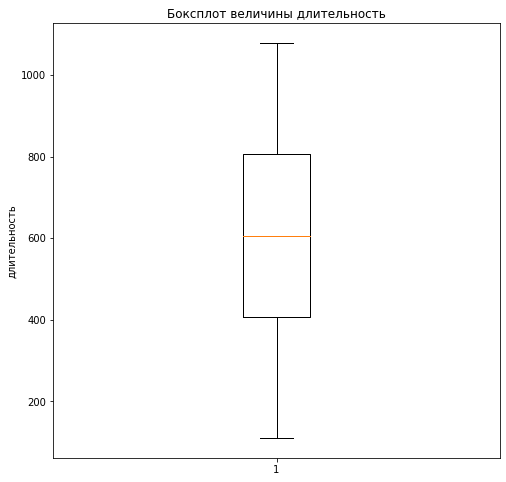

In [30]:
hist_show(market_file, 'длительность', bins=50)

Вывод: Данные выглядят хорошо, признак "длительность" лежит в интервале от 110.0 до 1079.00, то есть пользователи зарегестрированы на сайте от 3,6 месяцев до почти 3-х лет. На следующих шагах с помощью этого признака(и других признаков) мы сможем сформировать такие признаки как "время на сайте за предыдущий год" и "время на сайте за предыдущий месяц".

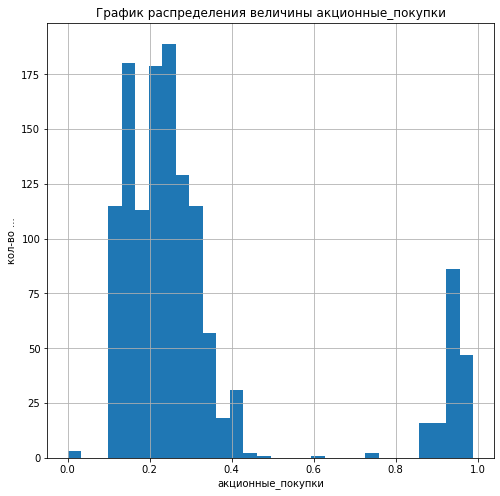

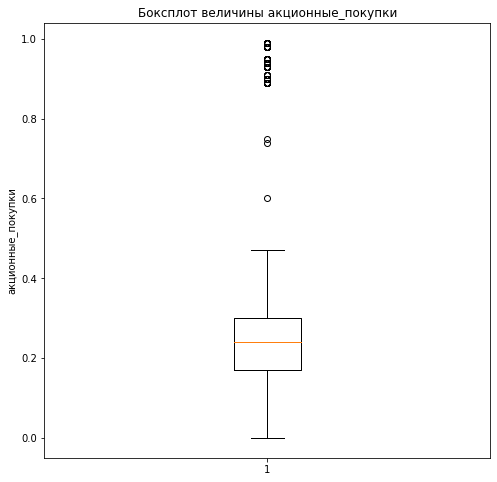

In [31]:
hist_show(market_file, 'акционные_покупки', bins=30)

Вывод: С данными все хорошо, думаю, здесь не нужно разделять на две категории, так как будет дисбаланс классов.

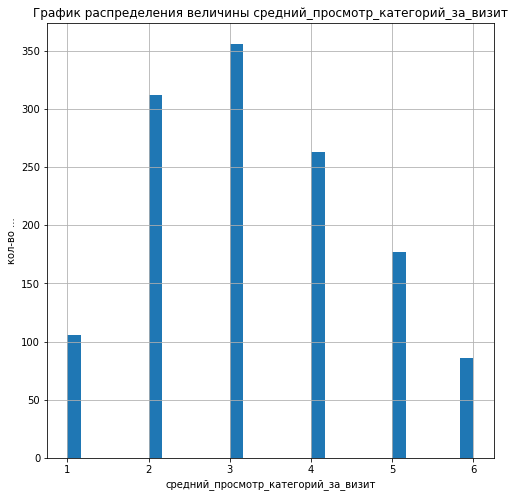

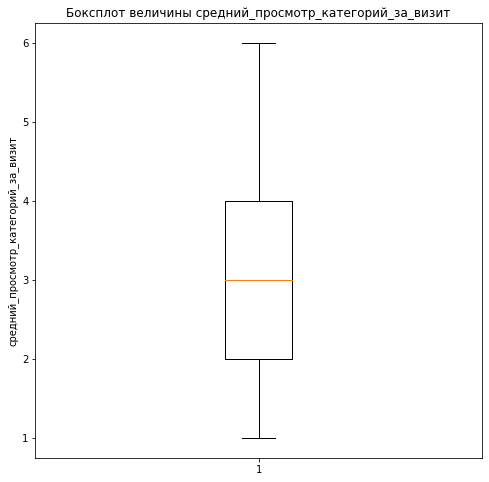

In [32]:
hist_show(market_file, 'средний_просмотр_категорий_за_визит', bins=30)

Вывод: Признак 'средний_просмотр_категорий_за_визит' имеет всего 6 значений, поэтому можем отнести его к кандидатам на перевод в категориальные признаки.

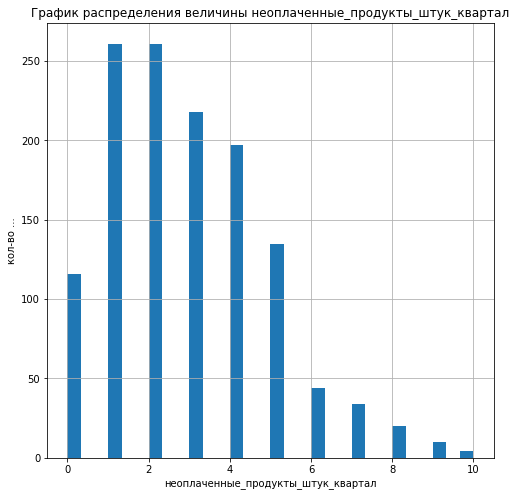

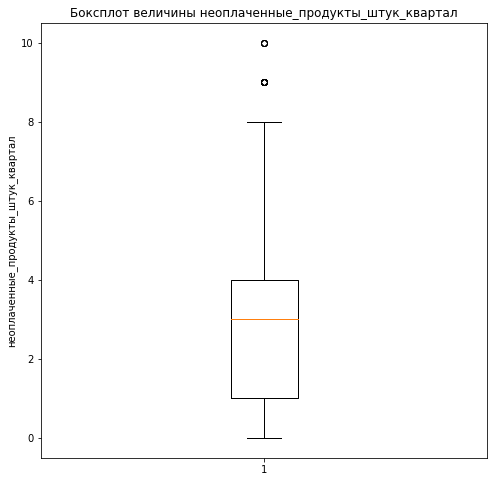

In [33]:
hist_show(market_file, 'неоплаченные_продукты_штук_квартал', bins=30)

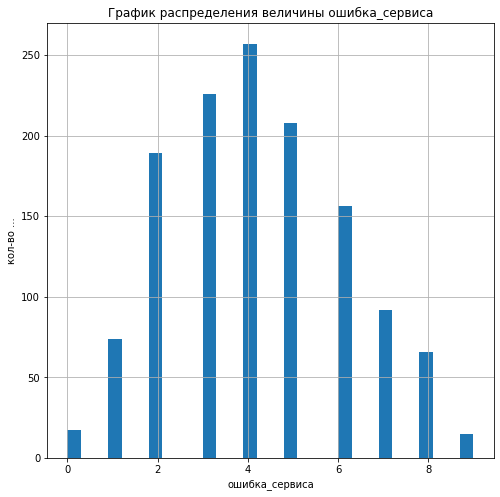

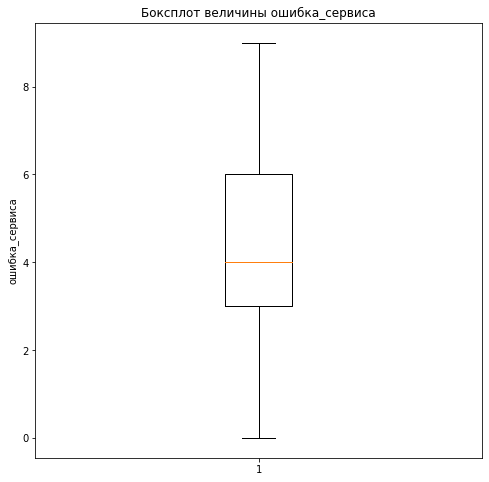

In [34]:
hist_show(market_file, 'ошибка_сервиса', bins=30)

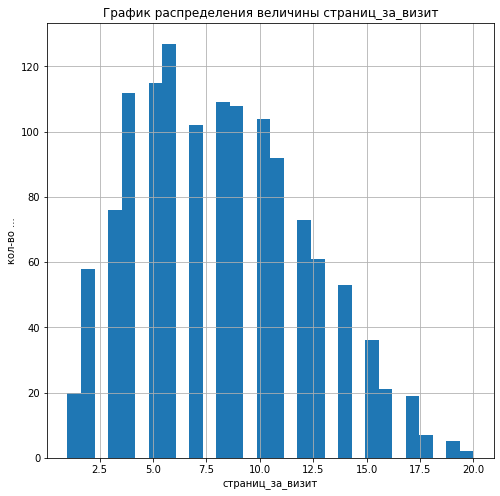

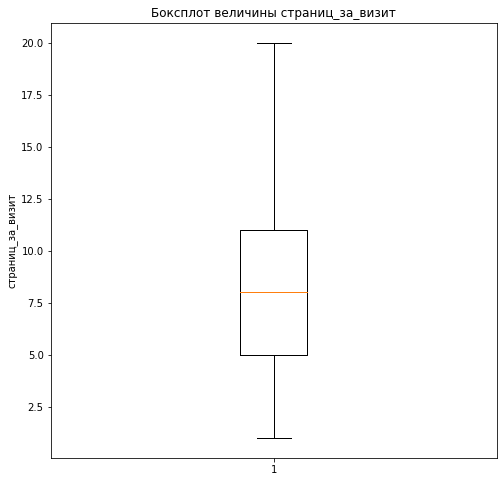

In [35]:
hist_show(market_file, 'страниц_за_визит', bins=30)

Вывод: Признаки "неоплаченные_продукты_штук_квартал", "ошибка_сервиса", "страниц_за_визит" выглядят адекватно, никаких аномалий нет.

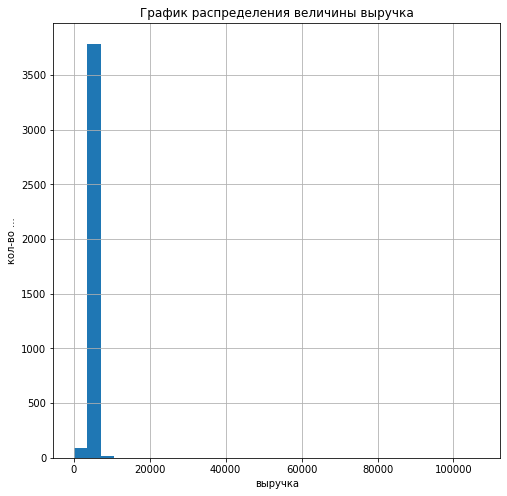

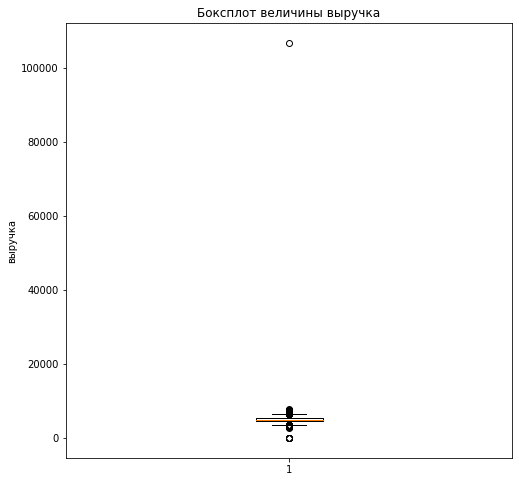

In [36]:
hist_show(market_money, 'выручка', bins=30)

В признаке "выручка" только одно значение выбивается. Выведем его на экран.

In [37]:
market_money[market_money['выручка'] > 100000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [38]:
market_file[market_file['id'] == 215380]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


In [39]:
market_time[market_time['id'] == 215380]

,id,период,минут
64,215380,предыдущий_месяц,12
65,215380,текущий_месяц,14


Вывод: Значение имеет место быть, но оно не повлияет на модель, поэтому можем его убрать из данных.

In [40]:
market_money = market_money.query('выручка < 100000')

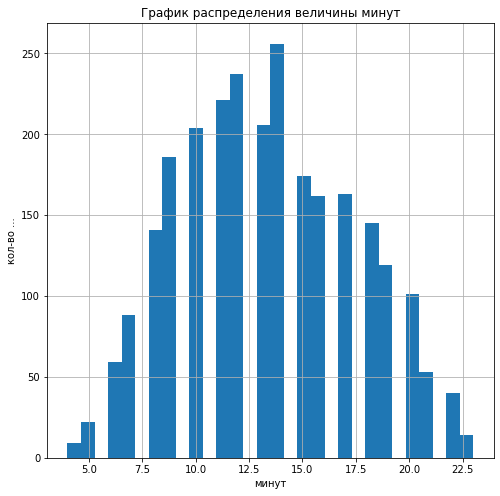

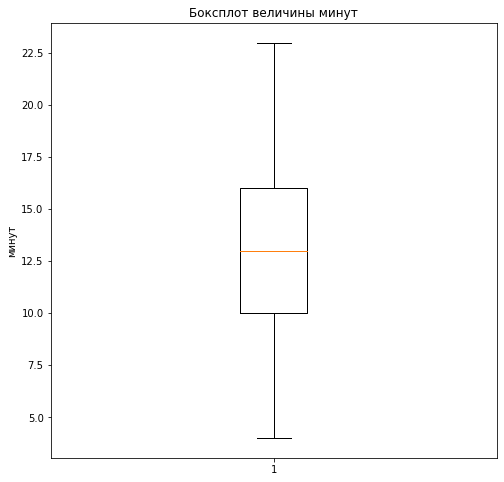

In [41]:
hist_show(market_time, 'минут', bins=30)

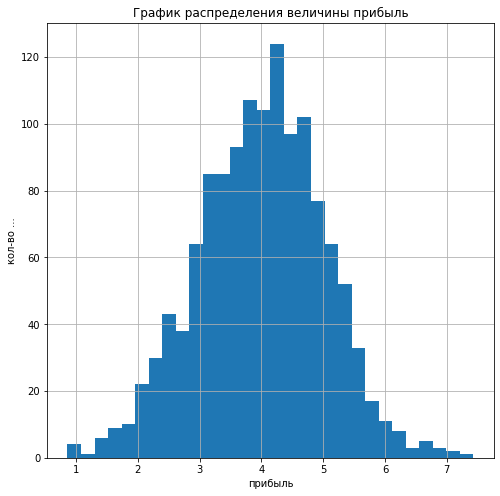

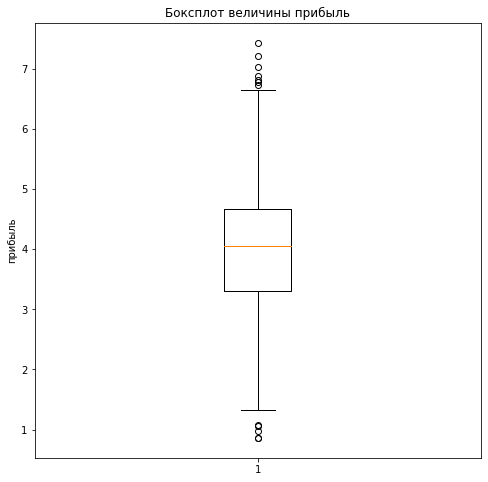

In [42]:
hist_show(money, 'прибыль', bins=30)

Вывод: Признаки "минут" и "прибыль" выглядят адекватно. Вбросы на боксплоте последнего признака имеют место быть в силу логики признака.

Напишем функцию для вывода распределения категориальных признаков:

In [43]:
def category_info(data, column):
    data.groupby(column).sum().plot(kind='pie', y='id', autopct='%1.0f%%',
     colors = ['steelblue', 'pink'],
     title='Points Scored by Team') 
    plt.title('Диаграмма распределения')

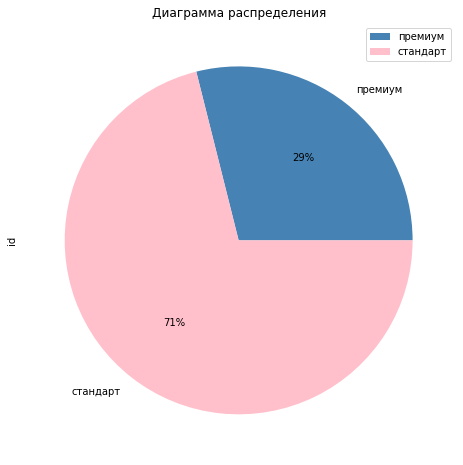

In [44]:
category_info(market_file, 'тип_сервиса')

Вывод: Дисбаланс признаков - тип "стандарт" занимает 0.7 от всех данных. В модель логистической регрессии заложим class_weight='balanced'. При необходимости будем решать проблему дисбаланса другими методами.

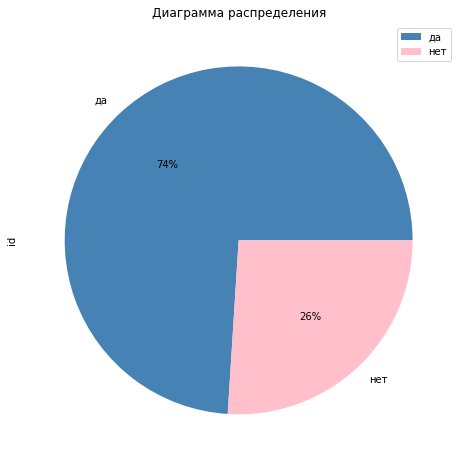

In [45]:
category_info(market_file, 'разрешить_сообщать')

Вывод: Дисбаланс признаков - тип "да" занимает 0.74 от всех данных. В модель логистической регрессии заложим class_weight='balanced'. При необходимости будем решать проблему дисбаланса другими методами.

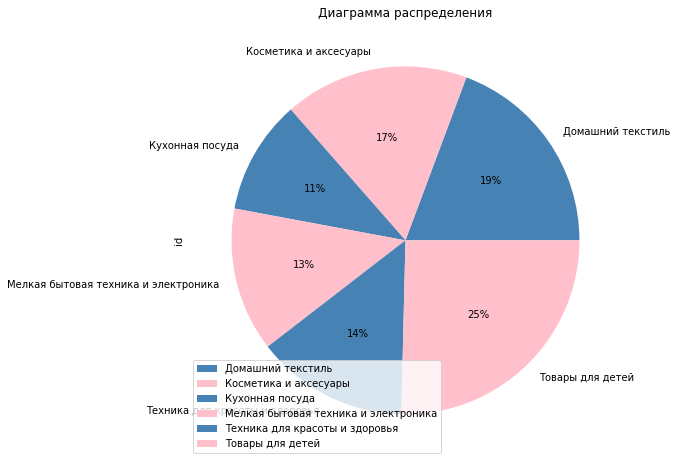

In [46]:
category_info(market_file, 'популярная_категория')

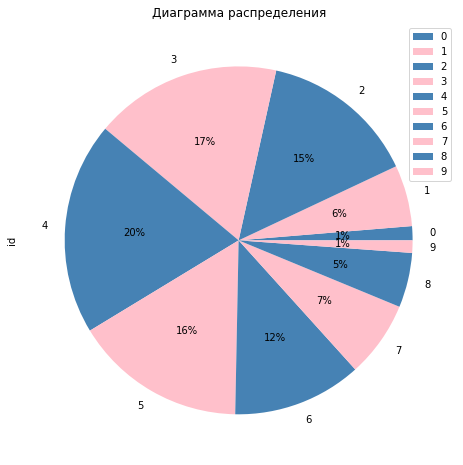

In [47]:
category_info(market_file, 'ошибка_сервиса')

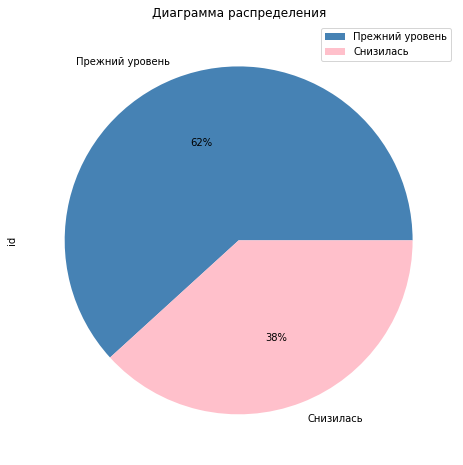

In [48]:
category_info(market_file, 'покупательская_активность')

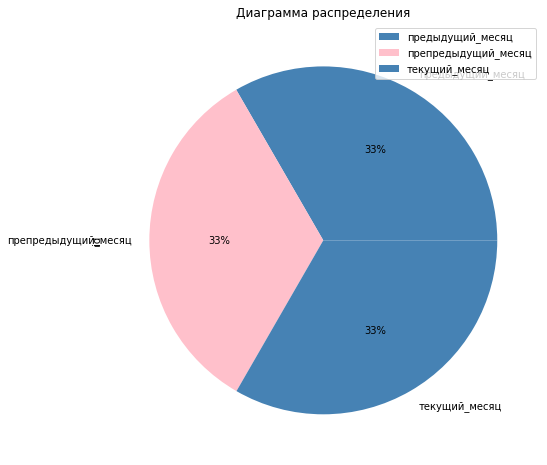

In [49]:
category_info(market_money, 'период')

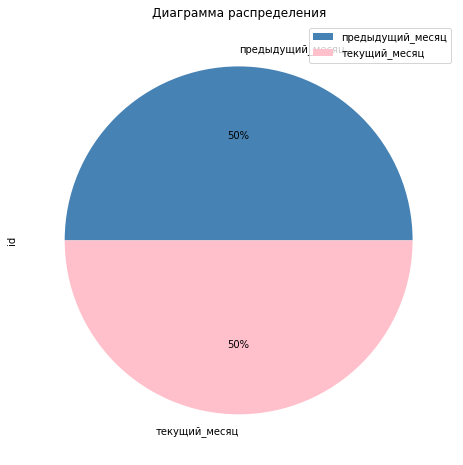

In [50]:
category_info(market_time, 'период')

In [51]:
market_money

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


Вывод: С дисбалансом классов мы столкнулись только в двух случаях - в дальнейшем, возможно, придется провести работу с данными для корректировки классового неравенства. Но для признака "тип_сервиса" - это органично, поскольку бОльшая часть пользователей предпочитает стандартную подписку из-за цены и отсутсвтия необходимости в доп. функциях, которые дает "премиум" подписка. 

### Шаг 4. Объединение таблиц



Перед тем как объединять столбцы, переименуем их, чтобы избежать проблем при объединении.

In [52]:
market_file['выручка_текущий_месяц'] = market_money.apply(lambda x : x['выручка'] if x['период'] == "текущий_месяц" else 0, axis=1)
market_file['выручка_предыдущий_месяц'] = market_money.apply(lambda x : x['выручка'] if x['период'] == "предыдущий_месяц" else 0, axis=1)
market_file['выручка_препредыдущий_месяц'] = market_money.apply(lambda x : x['выручка'] if x['период'] == "препредыдущий_месяц" else 0, axis=1)

In [53]:

market_file['минут_на_сайте_текущий_месяц'] = market_time.apply(lambda x : x['минут'] if x['период'] == "текущий_месяц" else 0, axis=1)
market_file['минут_на_сайте_предыдущий_месяц'] = market_time.apply(lambda x : x['минут'] if x['период'] == "предыдущий_месяц" else 0, axis=1)
market_file['минут_на_сайте_препредыдущий_месяц'] = market_time.apply(lambda x : x['минут'] if x['период'] == "препредыдущий_месяц" else 0, axis=1)

#market_money = market_money.drop(columns=['период'], axis=1)
#market_time = market_time.drop(columns=['период'], axis=1)

In [54]:
total_market = market_file.copy()

In [55]:
total_market.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,минут_на_сайте_текущий_месяц,минут_на_сайте_предыдущий_месяц,минут_на_сайте_препредыдущий_месяц
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000,1299.000000,1299.000000,1299.000000,1300.000000,1300.000000,1300.0
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923,1765.214550,1654.533102,1538.001540,5.897692,5.983077,0.0
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126,2557.337881,2396.667938,2192.583847,6.513880,6.582082,0.0
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000,0.000000,0.000000,0.000000,2.000000,2.500000,0.0
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000,4645.800000,4453.500000,4447.500000,11.000000,11.000000,0.0
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000,7799.400000,6869.500000,5555.000000,23.000000,23.000000,0.0


### Шаг 5. Корреляционный анализ.

С помощью библиоотеки phik сформируем и выведем на экран корреляционную матрицу признаков.

In [56]:
total_market.head(50)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,минут_на_сайте_текущий_месяц,минут_на_сайте_предыдущий_месяц,минут_на_сайте_препредыдущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,0.0,14,0,0
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,3293.1,0.0,0.0,0,13,0
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,0.0,0.0,0.0,10,0,0
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,0.0,0.0,4472.0,0,12,0
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4971.6,0.0,0.0,13,0,0
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,0.0,5216.0,0.0,0,8,0
6,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,0.0,0.0,4826.0,13,0,0
7,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,5058.4,0.0,0.0,0,11,0
8,215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,0.0,5457.5,0.0,11,0,0
9,215357,Снизилась,стандарт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5,6610.4,0.0,0.0,0,8,0


In [57]:
total_market = total_market.set_index('id')
total_market = total_market.drop(['минут_на_сайте_препредыдущий_месяц'], axis=1)
phik_matrix = total_market.phik_matrix(interval_cols=['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'страниц_за_визит', 'выручка', 'минут', 'прибыль'])
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

In [58]:
total_market

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,минут_на_сайте_текущий_месяц,минут_на_сайте_предыдущий_месяц
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,0.0,14,0
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,3293.1,0.0,0.0,0,13
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,0.0,0.0,0.0,10,0
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,0.0,0.0,4472.0,0,12
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4971.6,0.0,0.0,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,5379.6,0.0,0.0,0,20
216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,0.0,0.0,4950.0,0,11
216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,0.0,5404.5,0.0,22,0


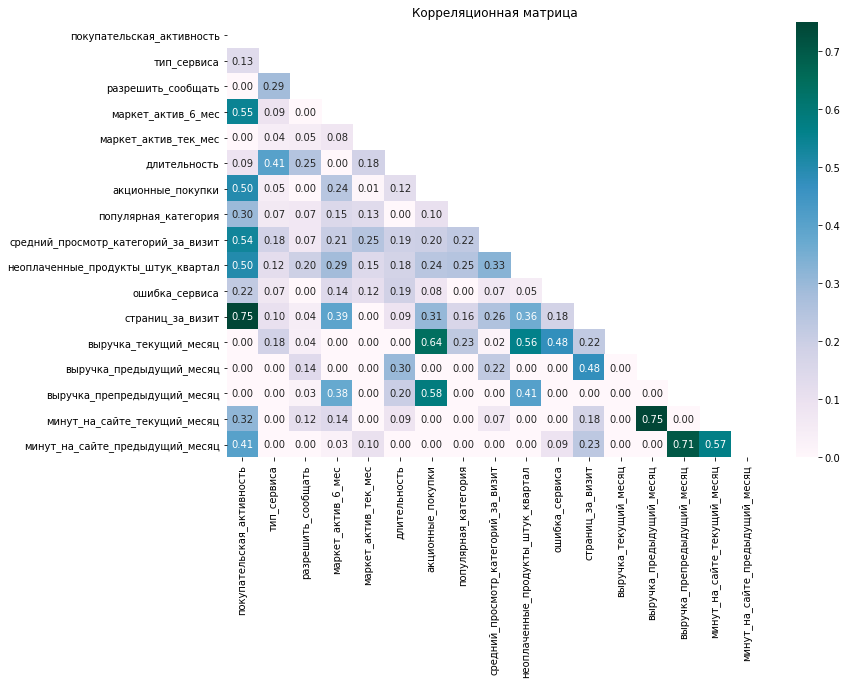

In [59]:
plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="PuBuGn", mask=mask)
plt.title("Корреляционная матрица")
plt.show()

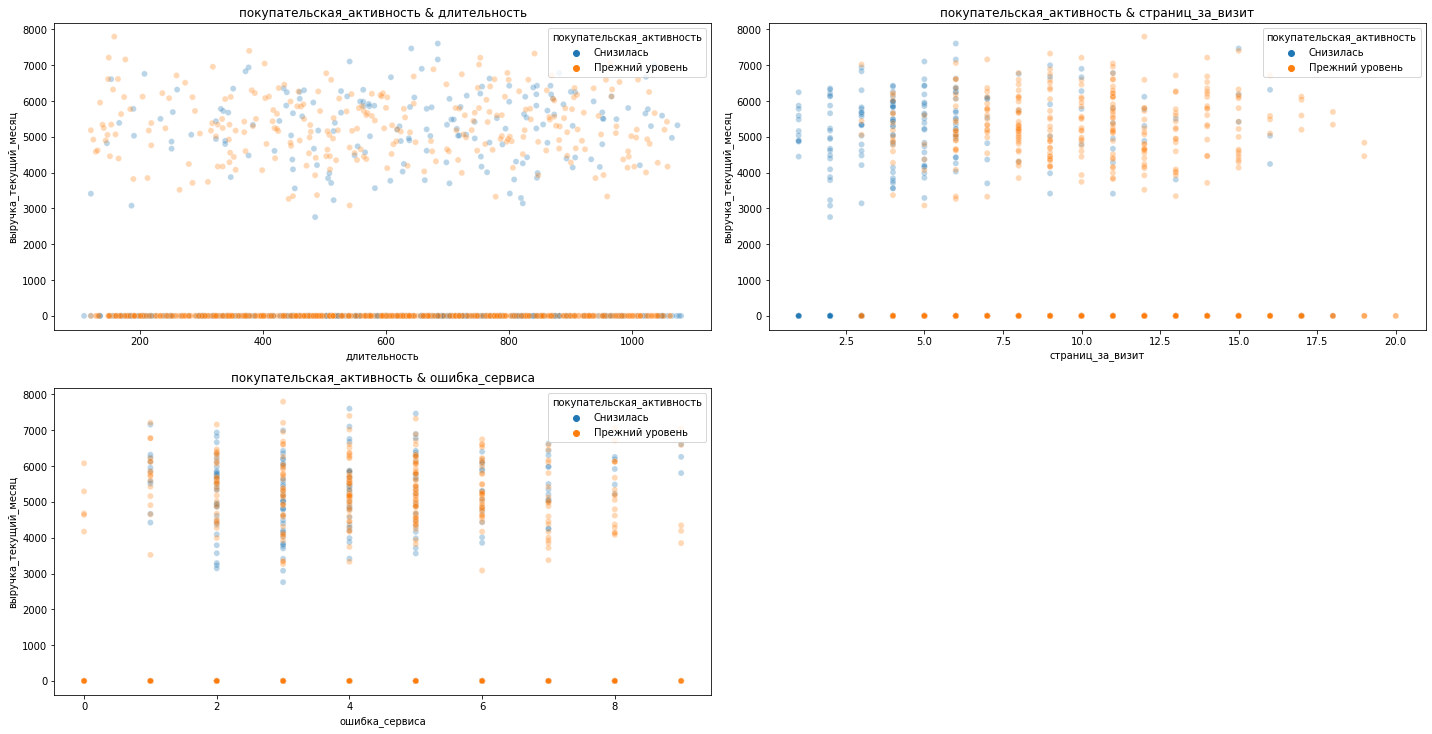

In [60]:
#Список количественных признаков 
quantitative_signs = ['длительность', 'страниц_за_визит', 'ошибка_сервиса']

#Диаграммы рассеяния
plt.figure(figsize=(20, 20))

for i, feature in enumerate(quantitative_signs, 1):
    plt.subplot(4, 2, i)
    sns.scatterplot(data=total_market, x=feature, y='выручка_текущий_месяц', hue='покупательская_активность', alpha=0.3)  #palette=['royalblue', 'red']
    plt.title(f'покупательская_активность & {feature}')

plt.tight_layout()
plt.show()

Вывод:
1. Мультиколлинеарности не обнаружено - нет плотного облака.  

2. По признаку "пользовательская_активность" самые высокие значения с "страниц_за_визит" и "минут" - 0.75 и 0.63 соответственно.

### Шаг 6. Использование пайплайнов
С помощью пайплайна:
1. Подготовим данные - кодируем категориальные признаки и масштабируем количественные.  
2. Обучим четыре модели - KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберем гиперпараметр. 
3. Выберем лучшую модель, используя один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт нам лучшую модель.

In [61]:
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

RANDOM_STATE = 42
TEST_SIZE = 0.25

# загружаем данные
df_full = total_market.copy()
df_full = df_full.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(['покупательская_активность'], axis=1),
    df_full['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_full['покупательская_активность'])

print(X_train.shape, X_test.shape)

(975, 16) (325, 16)


In [62]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [65]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
    )

In [66]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                
                ], 
                handle_unknown='error'
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [67]:
# создаём списки с названиями признаков
ohe_columns = ['популярная_категория', 'разрешить_сообщать']
ord_columns = ['тип_сервиса']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
               'средний_просмотр_категорий_за_визит',	'неоплаченные_продукты_штук_квартал',	'ошибка_сервиса',	'страниц_за_визит',	
               'выручка_препредыдущий_месяц',	'выручка_предыдущий_месяц', 'выручка_текущий_месяц',
                'минут_на_сайте_предыдущий_месяц', 'минут_на_сайте_текущий_месяц']

In [68]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
     ('ohe', ohe_pipe, ohe_columns),   
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [69]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


In [70]:
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [71]:
from sklearn.svm import SVC
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
        # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
        # словарь для модели SVC() 
    {
        'models': [SVC()],
        'models__kernel': ['linear', 'poly', 'sigmoid'],
        'models__degree': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                            

In [72]:
y_predict_proba = randomized_search.predict_proba(X_test)
# проверьте работу модели на тестовой выборке

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_predict_proba[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.9185925212646445


Вывод: лучшая модель - логистическая регрессия со следующими гиперпараметрами: C=6, penalty='l1', random_state=42,
                                    solver='liblinear'  
                                    
Метрика ROC-AUC модели на тренировочной выборке: 0.9254106470106471  
Метрика ROC-AUC на тестовой выборке: 0.9185925212646445

### Шаг 7. Отбор признаков

In [ ]:
pip install shap -q

In [88]:
pip install --upgrade scikit-learn

     |████████████████████████████████| 13.4 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 68.2 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


Подготовим данные для обучения лучшей модели:

In [75]:
import shap
shap.initjs()
#кодирование количественных признаков 
categorical_signs = ['популярная_категория', 'разрешить_сообщать', 'тип_сервиса']
# создайте экземпляр класса для заполнения пропусков на моду
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# посчитайте моду на тренировочной выборке
imputer.fit(X_train)
imputer.statistics_

# заполните пропуск в тестовых данных на моду
X_test[imputer.feature_names_in_] = imputer.transform(X_test)

#encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='error')

# обучите и преобразуйте категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[categorical_signs])
X_test_ohe = encoder.transform(X_test[categorical_signs])

#получаем названия новых столбцов 
#encoder_col_names = encoder.get_feature_names()
encoder_col_names = encoder.get_feature_names_out()

#датафрейм из закодированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

#нормализация quantitative_signs
quantitative_signs = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
               'средний_просмотр_категорий_за_визит',	'неоплаченные_продукты_штук_квартал',	'ошибка_сервиса',	'страниц_за_визит',	
               'выручка_препредыдущий_месяц',	'выручка_предыдущий_месяц', 'выручка_текущий_месяц',
                'минут_на_сайте_предыдущий_месяц', 'минут_на_сайте_текущий_месяц']

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[quantitative_signs])
X_test_scaled = scaler.transform(X_test[quantitative_signs])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=quantitative_signs)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=quantitative_signs)


X_train = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_test = pd.concat([X_test_scaled, X_test_ohe], axis=1)

In [78]:
from sklearn.metrics import accuracy_score

#обучим модель и оценим ее качество
model = LogisticRegression(C=6, penalty='l1', random_state=42,
                                    solver='liblinear')

model.fit(X_train, y_train)
acc0 = accuracy_score(y_test, model.predict(X_test))
print(acc0)

0.8553846153846154


Сперва построим график общей значимости признаков:

<AxesSubplot:ylabel='Feature'>

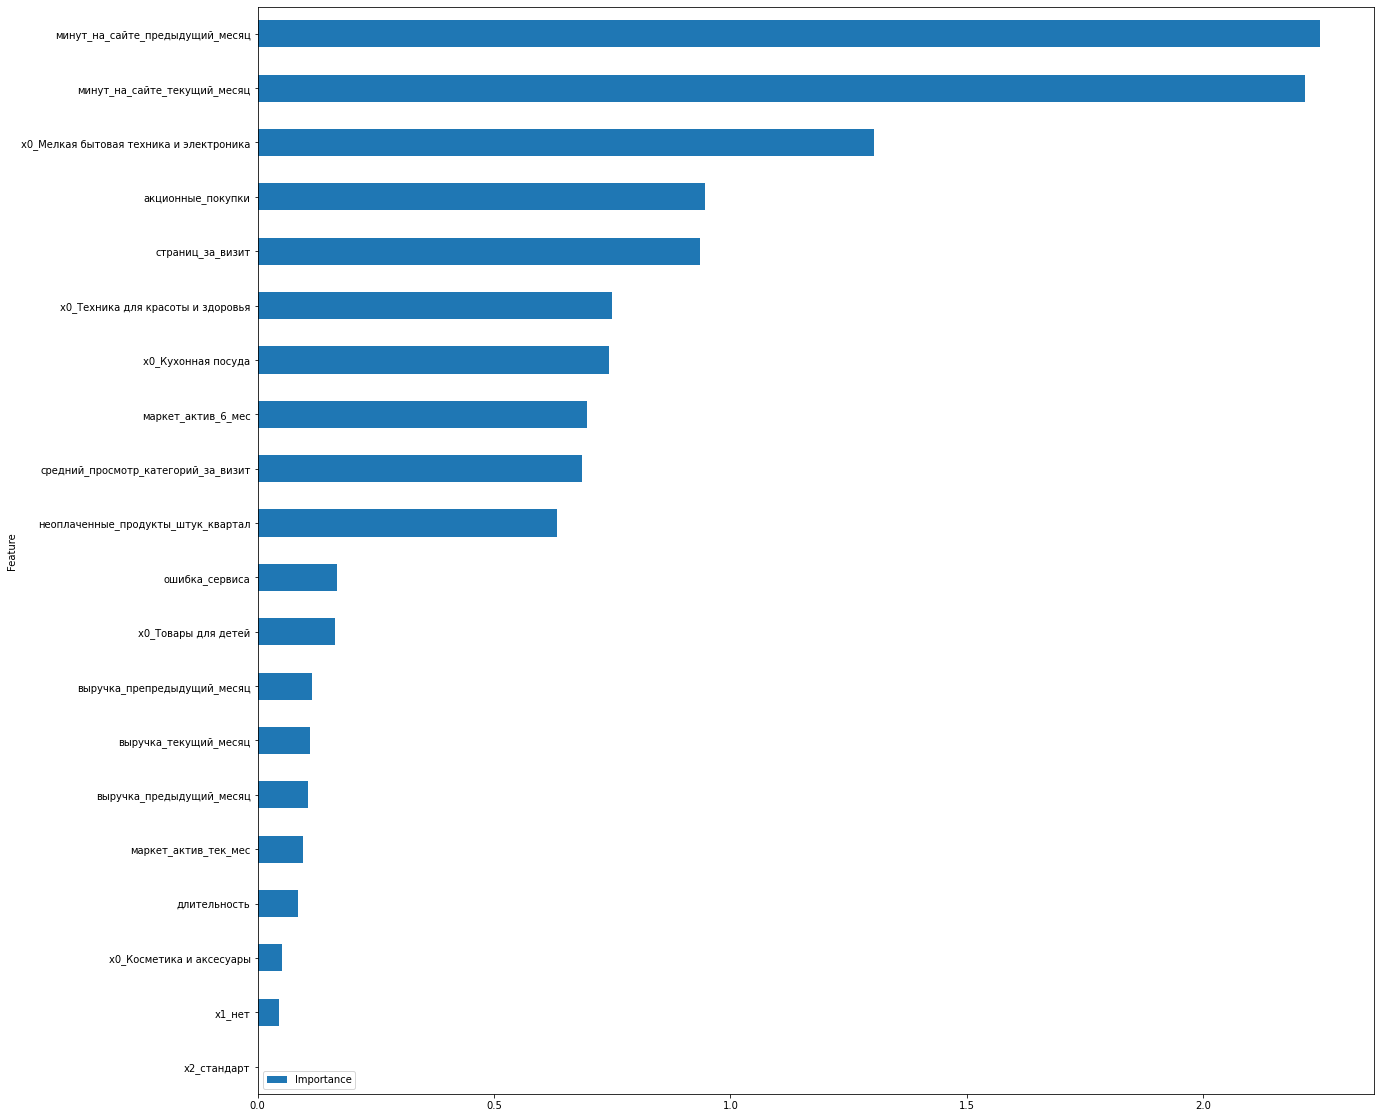

In [75]:
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train.columns.tolist(), 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(20, 20)) 

In [76]:
# стандартизация
X_train_scalled = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns.tolist())
X_test_scalled =  pd.DataFrame(scaler.transform(X_test),columns = X_train.columns.tolist())


In [77]:
X_test_df = pd.DataFrame(X_test,columns = X_train.columns.tolist())

In [78]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

accs = []

for i in range(len(X_test_df.columns)):
        # объявляем селектор 
    # он будет подбирать разное количество признаков за счёт цикла
    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train_scalled, y_train)
    
        # сохраняем названия признаков в переменную features_names
    features_names = selector.get_support(indices=True)

    # 1st way to get the list
    vector_names = list(X_train.columns[features_names])
    
    # стандартизируем признаки
    X_train_new = X_train_scalled[vector_names]
    X_test_new = X_test_scalled[vector_names]

    # инициализируем и обучаем модель
    model = LogisticRegression()
    model.fit(X_train_new, y_train)
    
    acc_new = accuracy_score(y_test, model.predict(X_test_new))

    # создаём таблицы предсказаний для подсчёта сэкономленных средств
    predicts = pd.DataFrame()
    predicts['logreg'] = []
    #X_test_df[['x3']].copy()
    predicts['logreg'] = model.predict(X_test_new)
    predicts['y_test'] = y_test.tolist()
    
    accs.append(acc_new)
    print(i, acc_new) 

0 0.8061538461538461
1 0.84
2 0.8523076923076923
3 0.8615384615384616
4 0.8676923076923077
5 0.8553846153846154
6 0.8646153846153846
7 0.8738461538461538
8 0.8676923076923077
9 0.8615384615384616
10 0.8646153846153846
11 0.8676923076923077
12 0.8707692307692307
13 0.8615384615384616
14 0.8584615384615385
15 0.8615384615384616
16 0.8615384615384616
17 0.8615384615384616
18 0.8615384615384616
19 0.8615384615384616


In [80]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=8)

selector.fit(X_train, y_train)
features_names = selector.get_support(indices=True)

# 1st way to get the list
vector_names = list(X_train.columns[features_names])
print(vector_names)

#2nd way
X_train.columns[selector.get_support(indices=True)].tolist()

print(features_names) 

['маркет_актив_6_мес', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минут_на_сайте_предыдущий_месяц', 'x0_Мелкая бытовая техника и электроника']
[ 0  3  4  5  6  7 11 15]


In [81]:
explainer = shap.KernelExplainer(model.predict_proba, X_train[:10])
shap_values = explainer(X_test[:10])

  0%|          | 0/10 [00:00<?, ?it/s]

In [82]:
shap.plots.beeswarm(shap_values, max_display = 21) 

ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!

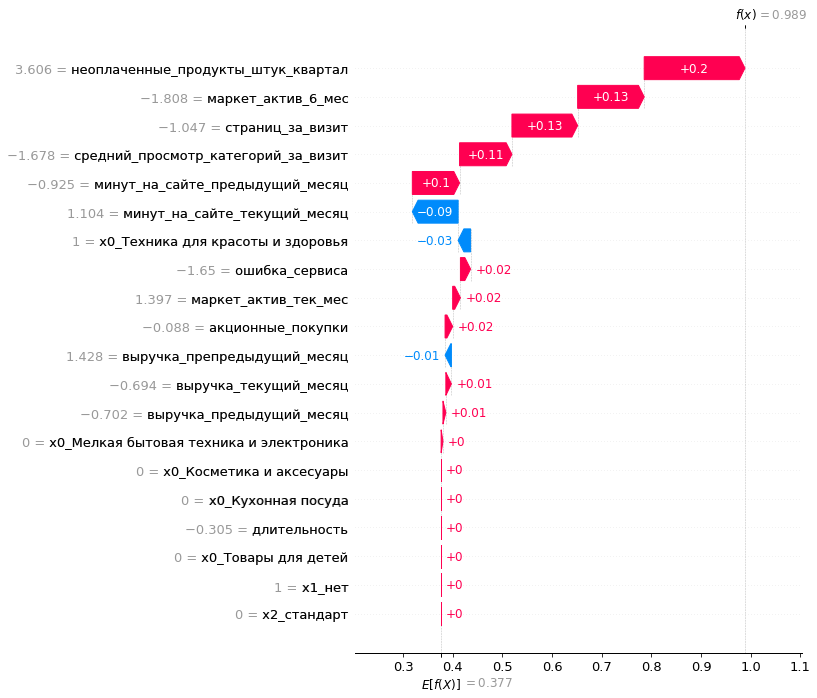

In [83]:
shap.plots.waterfall(shap_values[1,:,1], max_display = 21)

Промежуточный вывод: Для оценки качетсва работы модели мы выбрали метрику ROC_AUC - метрика отлично подходит для решения задач бинарной классификации. Площадь под графиком ROC-кривой  прекрасно справляется с тем чтобы показать сколь корректно упорядочены вероятности (как часто положительные объекты имеют меньшую вероятность положительности, чем негативные объекты).